In [1]:
%load_ext autotime
# %unload_ext autotime

In [2]:
import sys
sys.path.append("..")

In [13]:
import numpy as np
import parselmouth
import pyaudio
from sonorus.audio import VADAudioInputStreamer
from sonorus.audio.utils import audio_float2int
from sonorus.audio.praat import (reduce_noise, 
                                 change_gender, 
                                 change_pitch)
from sonorus.speech import Wav2Vec2Featurizer
from std_msgs.msg import UInt8MultiArray
from IPython.display import Audio
import librosa
import soundfile as sf
import ipywidgets
import pickle
import wave
from tqdm import tqdm
from pathlib import Path

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [4]:
libri_test_path = "/home/harold/Documents/IISc-work/local-speech-generation/datasets/LibriTTS/test-clean"
female_dir = "237"
male_dir = "260"

In [5]:
female_audio_array = []
female_file_array = []

male_audio_array = []
male_file_array = []

featurizer = Wav2Vec2Featurizer(gpu_idx=0)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
for directory, file_array, audio_array in \
        ((female_dir, female_file_array, female_audio_array),
         (male_dir, male_file_array, male_audio_array)):
    
    for file in tqdm((Path(libri_test_path)/directory)
                     .glob("**/*.wav")):
        file_array.append(file.name)
        audio, sr = librosa.load(file, sr=16000, dtype=np.float64)
        audio_array.append(featurizer.get_features(audio, sr)
                           .cpu().numpy()[0].mean(axis=0))

279it [00:34,  7.98it/s]
220it [00:26,  8.23it/s]


In [14]:
pca = PCA(n_components=50, random_state=42)
female_audio = pca.fit_transform(female_audio_array)
female_idx = np.zeros(len(female_audio))

male_audio = pca.transform(male_audio_array)
male_idx = np.ones(len(male_audio))

combined_audio = np.vstack((female_audio, male_audio))
combined_idx = np.hstack((female_idx, male_idx))
female_idx = (combined_idx==0)
male_idx = (combined_idx==1)

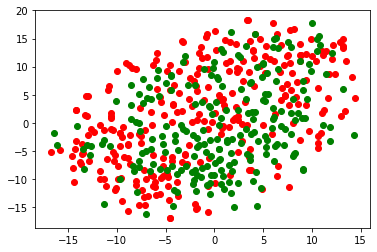

In [15]:
tsne = TSNE(n_components=2, random_state=42)
audio = tsne.fit_transform(combined_audio)
plt.scatter(audio[female_idx, 0], audio[female_idx, 1], c="r")
plt.scatter(audio[male_idx, 0], audio[male_idx, 1], c="g")

In [ ]:
male_file = "/home/harold/Downloads/chapter-33.wav"
# male_file = "/home/harold/Downloads/long.wav"
# male_file = "/home/harold/Downloads/coffee-01.wav"

In [ ]:
audio, sr = librosa.load(male_file, sr=24000, dtype=np.float64)
male_sound = parselmouth.Sound(values=audio, sampling_frequency=sr)
print(male_sound.values, male_sound.sampling_frequency)
Audio(data=male_sound.values, 
      rate=male_sound.sampling_frequency)

In [ ]:
noise_reduced_sound = male_sound
# noise_reduced_sound = reduce_noise(male_sound)
# print(noise_reduced_sound.values, 
#       noise_reduced_sound.sampling_frequency)
# Audio(data=noise_reduced_sound.values, 
#       rate=noise_reduced_sound.sampling_frequency)

In [ ]:
female_sound = change_gender(noise_reduced_sound, 
                             formant_shift_ratio=1.12,
                             pitch_range_factor=1.0)
print(female_sound.values, 
      female_sound.sampling_frequency)
Audio(data=female_sound.values, 
      rate=female_sound.sampling_frequency)

# def interactive_change_gender(sound_file=male_file, factor=1.2):
#     sound = parselmouth.Sound(sound_file)
#     sound_changed_gender = change_gender(sound, formant_shift_ratio=factor)
#     return Audio(data=sound_changed_gender.values, rate=sound_changed_gender.sampling_frequency)

# w = ipywidgets.interact(interactive_change_gender,
#                         factor=ipywidgets.FloatSlider(min=0.25, 
#                                                       max=4, 
#                                                       step=0.05, 
#                                                       value=1.2))

In [ ]:
pitch_sound = change_pitch(noise_reduced_sound, 
                           factor=1.5)
print(pitch_sound.values, 
      pitch_sound.sampling_frequency)
Audio(data=pitch_sound.values, 
      rate=pitch_sound.sampling_frequency)

# def interactive_change_pitch(sound_file=male_file, factor=1.5):
#     sound = parselmouth.Sound(sound_file)
#     sound_changed_pitch = change_pitch(sound, factor)
#     return Audio(data=sound_changed_pitch.values, rate=sound_changed_pitch.sampling_frequency)

# w = ipywidgets.interact(interactive_change_pitch,
#                         factor=ipywidgets.FloatSlider(min=0.25, 
#                                                       max=4, 
#                                                       step=0.05, 
#                                                       value=1.5))

In [ ]:
# sf.write(
#     file=male_file[:-4]+"-pitch-changed.wav",
#     data=audio_float2int(pitch_sound.values)[0],
#     samplerate=sr,
# )

In [ ]:
from kaldi.feat.mfcc import Mfcc, MfccOptions
from kaldi.feat.mel import MelBanksOptions
from kaldi.matrix import Vector
from kaldi.gmm import DiagGmm
from kaldi.base.io import istream, ifstream

In [ ]:
mel_opts = MelBanksOptions(num_bins=40)
mel_opts.low_freq = 20
mel_opts.high_freq = -400

mfcc_opts = MfccOptions()
mfcc_opts.num_ceps = 40
mfcc_opts.mel_opts = mel_opts
mfcc_opts.use_energy = False

mfcc = Mfcc(mfcc_opts)

In [ ]:
mfcc.compute(wave=Vector(pitch_sound.values[0]), vtln_warp=1)

In [ ]:
# gmm_path = "/home/harold/Documents/IISc-work/"\
#             "local-speech-generation/kaldi/s5/"\
#             "exp/nnet3_cleaned/extractor/final.dubm"
# stream = ifstream.from_file(gmm_path)
# dubm = DiagGmm.read(stream)

In [ ]:
from sonorus.speech.kaldi.create_confs import (create_mfcc_conf,
                                               create_ivector_extractor_conf)

from sonorus.speech.kaldi import PhonemeSegmenter

In [ ]:
phoneme_segmenter = PhonemeSegmenter.from_url(force_download=False)

In [ ]:
wav_file = "/home/harold/Pictures/data/test/chapter-33-pitch-changed.wav"
wav_scp = "/home/harold/Pictures/data/test/wav.scp"
spk2utt = "/home/harold/Pictures/data/test/spk2utt"

In [ ]:
seg = phoneme_segmenter.segment(pitch_sound.values, sample_rate=sr)
seg

In [ ]:
from hr.lip_control import PhonemesPublisher

phoneme_pub = PhonemesPublisher()
phoneme_pub.to_visemes(seg["utt1"]["phonemes"])

In [ ]:
from sonorus.audio import VADAudioInputStreamer

In [ ]:
audio_streamer = VADAudioInputStreamer(
    pa_format=pyaudio.paInt16, 
)

with audio_streamer as streamer:
        for stream in streamer.stream():
            if stream is not None:
                audio = np.frombuffer(stream, dtype=np.int16)
                print(audio.shape, audio[:5])
                phonemes = phoneme_segmenter.segment(
                    audio, sample_rate=streamer.processing_rate)
                print(phonemes)